In [63]:
import gym
import gym_sokoban
import numpy as np
import warnings
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import *
import copy
warnings.filterwarnings('ignore')

In [2]:
env_name = "Boxoban-Basic"
env = gym.make(env_name)

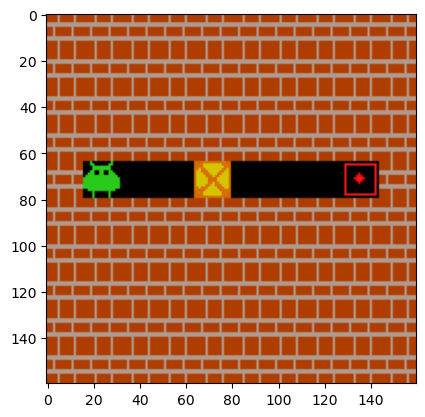

In [58]:
plt.imshow(env.reset())


In [65]:
env_ = copy.copy(env)

In [4]:
env.room_state

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 1, 1, 4, 1, 1, 1, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [5]:
env.action_space.n

5

In [37]:
def calc_reward():
        """
        Calculate Reward Based on
        :return:
        """
        # Every step a small penalty is given, This ensures
        # that short solutions have a higher reward.
        penalty_for_step = -0.1
        room_state = env.room_state
        room_fixed = env.room_fixed
        num_boxes = 1
        reward_box_on_target = 1
        penalty_box_off_target = -1
        reward_finished = 10
        reward_last = penalty_for_step
        boxes_on_target = np.where(env.room_state == 3)[0].shape[0]
        # count boxes off or on the target
        empty_targets = room_state == 2
        player_on_target = (room_fixed == 2) & (room_state == 5)
        total_targets = empty_targets | player_on_target

        current_boxes_on_target = num_boxes - \
                                  np.where(total_targets)[0].shape[0]

        # Add the reward if a box is pushed on the target and give a
        # penalty if a box is pushed off the target.
        if current_boxes_on_target > boxes_on_target:
            reward_last += reward_box_on_target
        elif current_boxes_on_target < boxes_on_target:
            reward_last += penalty_box_off_target
        
        game_won = env.check_if_all_boxes_on_target()        
        if game_won:
            reward_last += reward_finished
        
        boxes_on_target = current_boxes_on_target
        return reward_last


In [57]:
calc_reward()

9.9

In [61]:
R.shape

(8, 5, 8)

In [6]:
availabel_states = []
for i in range(10):
    for j in range(10):
        if env.room_state[i][j] != 0:
            availabel_states.append((i, j))
CHANGE_COORDINATES = {
    0: (0, 0),
    1: (-1, 0),
    2: (1, 0),
    3: (0, -1),
    4: (0, 1)
}
def get_next_state(state):
    new_states = []
    for i in CHANGE_COORDINATES.values():
        state_ = state + np.array(i)
        if tuple(state_) in availabel_states:
            new_states.append(state_)
    return new_states

In [7]:
type(availabel_states[0])

tuple

In [8]:
get_next_state([4,2])

[array([4, 2]), array([4, 1]), array([4, 3])]

In [9]:
len(get_next_state([4,2]))

3

In [10]:
def create_transition_pos(env):
    P = {}
    for state in availabel_states:
        for action in range(5):
            next_states = get_next_state(state)
            num_next_states = len(next_states)
            prob = [1/ num_next_states] * num_next_states
            P[(state, action)] = list(zip(next_states, prob))
    return P

In [11]:
def calculate_num_states(map):
    num_player_positions = np.count_nonzero(map != 0)
    num_box = np.count_nonzero(map == 2)
    num_box_positions = factorial(num_player_positions) / (factorial(num_box) * factorial(num_player_positions - num_box))
    num_states = num_box_positions * num_player_positions
    return int(num_states)

In [12]:
calculate_num_states(env.room_state)

64

In [13]:
def init_Qtable(n_states, n_actions):
    """Initializes the Q-table.
    
    Args:
        n_states: The number of states in the environment.
        n_actions: The number of actions in the environment.
    
    Returns:
        A numpy array of size [n_states, n_actions] containing all zeros.
    """
    return np.zeros((n_states, n_actions))

In [14]:
def greedy_policy(Qtable, state):
    action = np.argmax(Qtable[state][:])
    return action

In [15]:
def epsilon_greedy_policy(Qtable, state, epsilon):
    if np.random.random() < epsilon:
        action = env.action_space.sample()
    else:
        action = greedy_policy(Qtable, state)
    return action

In [16]:
#Training parameters
n_training_episodes = 10000
lr = 0.7

#Evaluation parameters
n_eval_episodes = 100

#Env parameters
# env_id = "Sokoban-v0"
max_steps = 1000
gamma = 0.95
eval_seed = []

max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

In [17]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
    for episode in tqdm(range(n_training_episodes)):
        epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate * episode)
        state = env.reset()
        done = False
        step = 0

        for step in range(max_steps):
            action = epsilon_greedy_policy(Qtable, state, epsilon)

            new_state, reward, done, info = env.step(action)

            Qtable[state][action] = Qtable[state][action] + lr * (reward + gamma * np.max(Qtable[new_state][:]) - Qtable[state][action])
            if done:
                break
            state = new_state
    return Qtable

In [18]:
def policy_evaluation(policy, S):
    V = {s: 0 for s in S}
    while True:
        oldV = V.copy()
        
        for s in S:
            a = policy[s]
            V[s] = R(s, a) + sum(P(s_next, s, a) * oldV[s_next] 
                                 for s_next in S)
        if all(oldV[s] == V[s] for s in S):
            break
    return V

In [ ]:
def policy_improvement(V, S, A):
    policy = {s: A[0] for s in S}

    for s in S:
        Q = {}
        for a in A:
            Q[a] = R(s, a) + sum(P(s_next, s, a) * V[s_next] 
                                 for s_next in S)
        policy[s] = max(Q, key=Q.get)
    return policy

In [ ]:
def policy_iterations(S, A, P, R):
    """
    :param list S: set of states
    :param list A: set of actions
    :param dict P: transition function P(s'|s,a)
    :param dict R: reward function R(s,a,s')
    """
    policy = {s: A[0] for s in S}
    while True:
        old_policy = policy.copy()

        V = policy_evaluation(policy, S)
        policy = policy_improvement(V, S, A)

        if all(old_policy[s] == policy[s] for s in S):
            break
    return policy